In [1]:
import pandas as pd
import numpy as np
import json
import matplotlib.pyplot as plt
pd.set_option('display.max_columns', None)
import os
plt.rcParams["figure.figsize"]=14,5
import holidays
from datetime import timedelta, datetime
import warnings
warnings.filterwarnings("ignore")
import sys
import datetime


os.environ['TF_CPP_MIN_LOG_LEVEL'] = '2'
import tensorflow as tf
import seaborn as sns
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score
from tabulate import tabulate
import requests
from sklearn.cluster import DBSCAN
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler
from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import MinMaxScaler
import joblib
import tensorflow as tf
# logger.info(f"tf version:{tf.__version__}")
# from tensorflow import keras
from tensorflow.keras import layers                         # type: ignore
from tensorflow.keras.models import Sequential              # type: ignore
from tensorflow.keras.layers import LSTM, Dense, Dropout    # type: ignore
from tensorflow.keras import regularizers                   # type: ignore
# from sklearn.inspection import permutation_importance
np.set_printoptions(precision=3, suppress=True)
import pickle
from xgboost import XGBRegressor
from sklearn.model_selection import RandomizedSearchCV, TimeSeriesSplit
from math import sqrt


In [2]:
df_complete_data = pd.read_parquet('HT_meter_complete_data_9_id.parquet')
df = df_complete_data[df_complete_data['sensor']=="6148740eea9db0.29702291"]  ## Jamia HT METER
df = df.copy()

df.drop("sensor", axis=1, inplace=True)
print(f"df rows: {len(df)}")
print(f"Duplicated rows: {df.duplicated().sum()}")
df.set_index("creation_time", drop=True, inplace=True)
df = df.loc[df.index.year>2022]
df = df.loc[~ ((df.index.year==2024) & (df.index.month>5))]

print(f"Duplicated rows after datetime index: {df.duplicated().sum()}")
df = df.drop_duplicates()
df = df[df['R_Voltage'] != 0]
# df = df.loc[~df['R_Voltage'] == 0]
print(f"Duplicated index: {df.index.duplicated().sum()}")
print(f"null_values : \n{df.isna().sum()}")
print(f"df rows after basic checks: {len(df)}")
df

df rows: 32351
Duplicated rows: 0
Duplicated rows after datetime index: 38
Duplicated index: 0
null_values : 
R_Voltage    0
Y_Voltage    0
B_Voltage    0
R_Current    0
Y_Current    0
B_Current    0
KWh          0
dtype: int64
df rows after basic checks: 24777


,R_Voltage,Y_Voltage,B_Voltage,R_Current,Y_Current,B_Current,KWh
creation_time,,,,,,,
2023-01-01 00:00:00,6392.0,6352.0,6397.0,5.02,5.68,5.09,48.3
2023-01-01 00:30:00,6418.0,6379.0,6426.0,4.39,5.14,4.82,42.7
2023-01-01 01:00:00,6418.0,6380.0,6428.0,4.81,3.78,5.11,40.4
2023-01-01 01:30:00,6436.0,6399.0,6449.0,3.49,3.06,4.05,29.6
2023-01-01 02:00:00,6447.0,6411.0,6460.0,3.69,3.26,4.27,32.1
...,...,...,...,...,...,...,...
2024-05-31 21:30:00,6266.0,6296.0,6294.0,24.90,24.04,25.35,228.3
2024-05-31 22:00:00,6228.0,6256.0,6256.0,26.73,25.31,24.82,235.3
2024-05-31 22:30:00,6215.0,6248.0,6241.0,27.74,27.69,26.61,252.0


In [3]:
df.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 24777 entries, 2023-01-01 00:00:00 to 2024-05-31 23:30:00
Data columns (total 7 columns):
 #   Column     Non-Null Count  Dtype  
---  ------     --------------  -----  
 0   R_Voltage  24777 non-null  float64
 1   Y_Voltage  24777 non-null  float64
 2   B_Voltage  24777 non-null  float64
 3   R_Current  24777 non-null  float64
 4   Y_Current  24777 non-null  float64
 5   B_Current  24777 non-null  float64
 6   KWh        24777 non-null  float64
dtypes: float64(7)
memory usage: 2.0 MB


In [4]:
df.describe()

,R_Voltage,Y_Voltage,B_Voltage,R_Current,Y_Current,B_Current,KWh
count,24777.000000,24777.000000,24777.000000,24777.000000,24777.000000,24777.000000,24777.000000
mean,6211.139767,6217.494531,6198.344836,8.942015,8.839981,9.660236,81.742374
std,159.226051,163.230999,153.347449,5.240736,4.572159,4.695005,44.207736
min,5427.000000,383.000000,5608.000000,1.970000,1.700000,1.920000,0.700000
25%,6103.000000,6111.000000,6092.000000,4.880000,5.270000,5.990000,47.700000
50%,6207.000000,6217.000000,6197.000000,7.650000,7.880000,8.720000,71.700000
75%,6320.000000,6329.000000,6305.000000,11.570000,11.250000,12.240000,104.200000
max,6923.000000,6911.000000,6848.000000,36.280000,33.320000,36.460000,314.000000


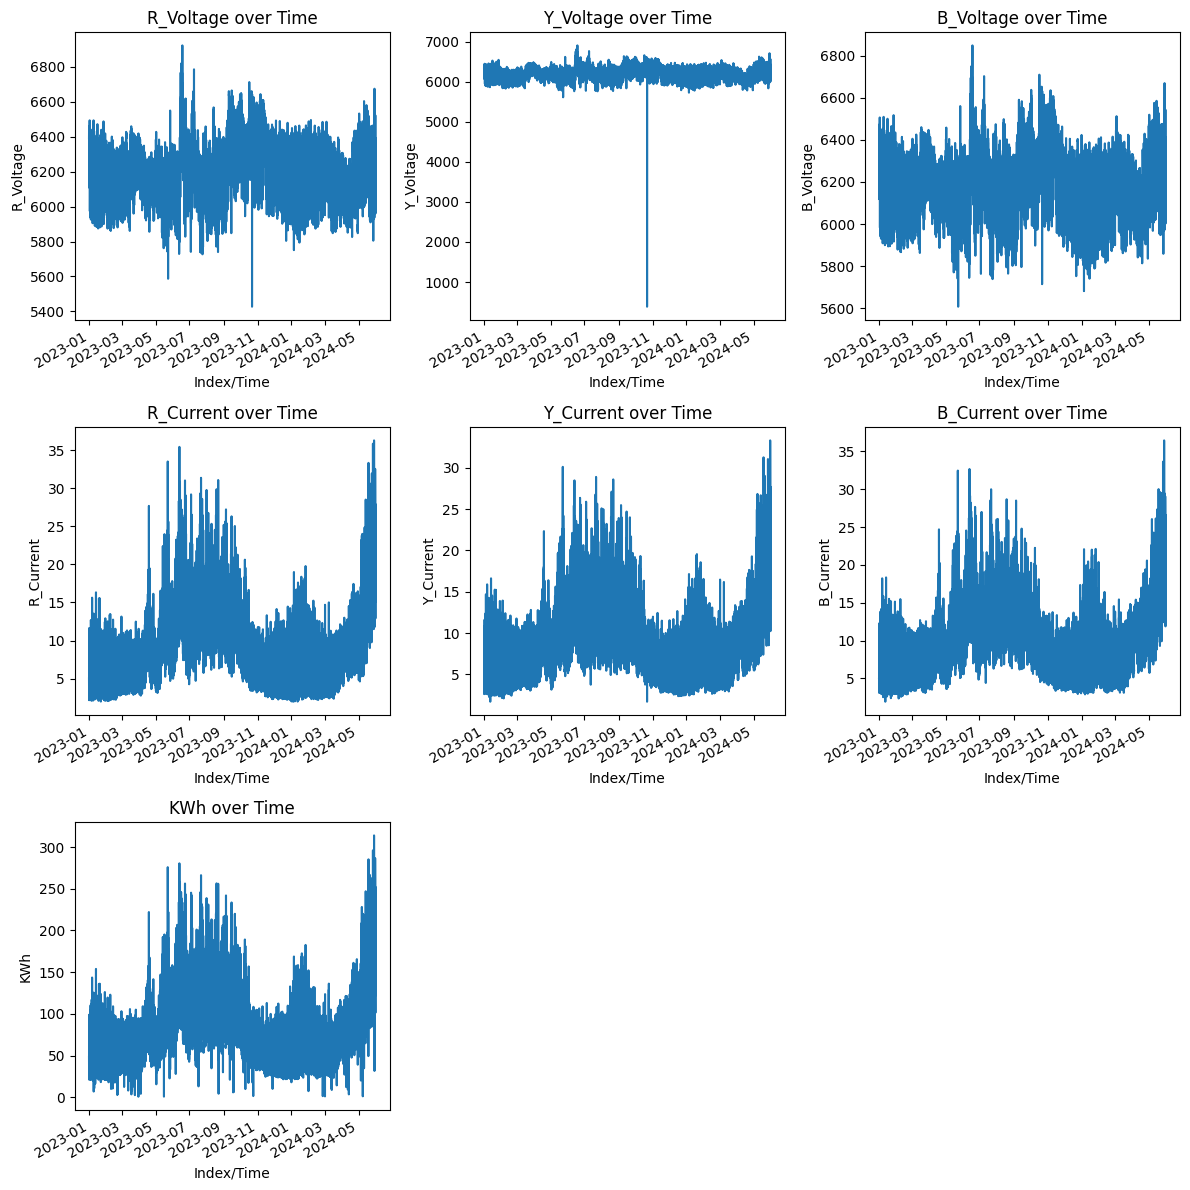

In [5]:
import matplotlib.pyplot as plt

# Define the number of columns for subplots
n_cols = 3  # Adjust this based on how many columns you want per row
n_rows = (len(df.columns) + n_cols - 1) // n_cols  # Calculate the number of rows needed

# Create subplots
fig, axes = plt.subplots(n_rows, n_cols, figsize=(12, 4 * n_rows))  # Adjust the figure size as needed
axes = axes.flatten()  # Flatten the axes array for easier indexing

# Loop through each column in the DataFrame
for i, col in enumerate(df.columns):
    df[col].plot(ax=axes[i])  # Plot on the corresponding subplot
    axes[i].set_title(f"{col} over Time")  # Set the title for each subplot
    axes[i].set_ylabel(col)  # Set the y-label for each subplot
    axes[i].set_xlabel("Index/Time")  # Set the x-label for each subplot

# Remove any empty subplots (if there are fewer columns than subplots)
for j in range(i + 1, len(axes)):
    fig.delaxes(axes[j])

plt.tight_layout()  # Adjust layout to avoid overlap
plt.show()  # Show the plot


In [5]:
df.columns

Index(['R_Voltage', 'Y_Voltage', 'B_Voltage', 'R_Current', 'Y_Current',
       'B_Current', 'KWh'],
      dtype='object')

In [6]:

df.loc[(df['R_Voltage']<5000 )| (df['Y_Voltage']<5000 )|(df['B_Voltage']<5000 )]

,R_Voltage,Y_Voltage,B_Voltage,R_Current,Y_Current,B_Current,KWh
creation_time,,,,,,,
2023-10-21 23:00:00,5591.0,383.0,5715.0,5.34,1.70,7.41,34.7
2023-10-21 23:30:00,5427.0,547.0,5926.0,5.14,1.86,7.37,28.5


In [7]:

df.loc[(df['R_Current']<1 )| (df['Y_Current']<1 )|(df['B_Current']<1 )]

,R_Voltage,Y_Voltage,B_Voltage,R_Current,Y_Current,B_Current,KWh
creation_time,,,,,,,


In [8]:
df[['KWh']].describe()

,KWh
count,24777.000000
mean,81.742374
std,44.207736
min,0.700000
25%,47.700000
50%,71.700000
75%,104.200000
max,314.000000


In [9]:
print((119-51)+(2*119))
print((119-51)-(1.5*51))


306
-8.5


In [10]:
df.loc[df['KWh']>306]

,R_Voltage,Y_Voltage,B_Voltage,R_Current,Y_Current,B_Current,KWh
creation_time,,,,,,,
2024-05-29,6193.0,6226.0,6217.0,36.28,30.07,36.46,314.0


null vlaues after resampling: 39
null values after filling: 0


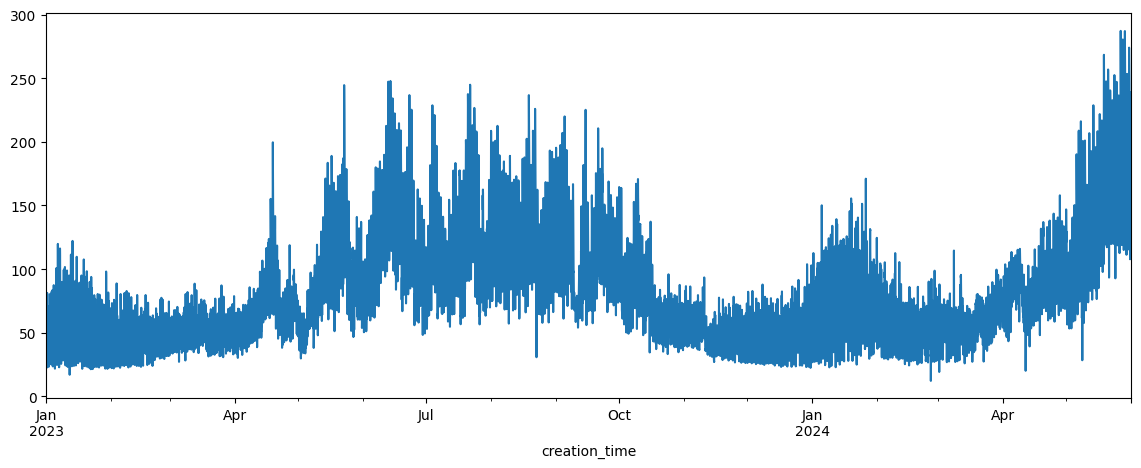

,KWh
creation_time,
2023-01-01 00:00:00,NaN
2023-01-01 00:30:00,NaN
2023-01-01 01:00:00,NaN
2023-01-01 01:30:00,40.250
2023-01-01 02:00:00,36.200
...,...
2024-05-31 21:30:00,184.975
2024-05-31 22:00:00,205.225
2024-05-31 22:30:00,228.850


In [83]:
resample_df = df[['KWh']].resample(rule="30min").asfreq()
print(f"null vlaues after resampling: {resample_df.isna().sum().sum()}")
# resample_df[resample_df.isna().any(axis=1)]
resample_df = resample_df.interpolate(method="linear")
print(f"null values after filling: {resample_df.isna().sum().sum()}")
resample_df['KWh'] = resample_df['KWh'].rolling(window=4).mean()
resample_df['KWh'].plot()
plt.show()
resample_df

## feature engineering

In [47]:
def holidays_list(start_date, end_date):
    holiday_list = []
    india_holidays = holidays.CountryHoliday('India', years=start_date.year)
    # Iterate through each date from start_date to end_date
    current_date = start_date
    while current_date <= end_date:
        # Check if the current date is a holiday in India or a Sunday
        if current_date in india_holidays or current_date.weekday() == 6:
            holiday_list.append(current_date)
        current_date += timedelta(days=1)

    return holiday_list


def correlation_matrix(df):
    correlation_matrix_data = df.corr()
    # Set up the matplotlib figure
    plt.figure(figsize=(18, 10))
    # Draw the heatmap
    sns.heatmap(correlation_matrix_data, annot=True, fmt=".2f", cmap='coolwarm', square=True, linewidths=0.5)
    # Show the plot
    plt.show()

def add_lags(dff, target_col, large_data= False):
    # target_map = dff['consumed_unit'].to_dict()
    target_map = dff[target_col].to_dict()

    # 1 Hour, 2 Hours, 6 Hours
    dff['lag1_hour']   =  (dff.index - pd.Timedelta('1 hour')).map(target_map)
    dff['lag2_hours']  =  (dff.index - pd.Timedelta('2 hours')).map(target_map)
    dff['lag3_hours']  =  (dff.index - pd.Timedelta('3 hours')).map(target_map)
    # dff['lag6_hours']  =  (dff.index - pd.Timedelta('6 hours')).map(target_map)
    # dff['lag12_hours'] =  (dff.index - pd.Timedelta('12 hours')).map(target_map)
    dff['lag1_day']    =  (dff.index - pd.Timedelta('1 day')).map(target_map)
    # dff['lag2_days']   =  (dff.index - pd.Timedelta('2 days')).map(target_map)
    # dff['lag3_days']   =  (dff.index - pd.Timedelta('3 days')).map(target_map)
    dff['lag7_days']   =  (dff.index - pd.Timedelta('7 days')).map(target_map)

    # if large_data:
    # dff['lag_15_day'] = (dff.index - pd.Timedelta('15 days')).map(target_map)
    dff['lag_30_day'] = (dff.index - pd.Timedelta('30 days')).map(target_map)
    # dff['lag_45_day'] = (dff.index - pd.Timedelta('45 days')).map(target_map)
        # logger.info(f" lags added for large data")
    #     return dff
    # else:
    
    dff['daily_avg'] = dff[target_col].rolling(window=48).mean()  # 24-hour rolling mean
    dff['weekly_avg'] = dff[target_col].rolling(window=7*48).mean()  # Weekly rolling mean


    # logger.info(f"lags added")
    return dff



def create_features(hourly_data,lagre_data= False):

    hourly_data = hourly_data.copy()
    # Check if the index is in datetime format
    if not isinstance(hourly_data.index, pd.DatetimeIndex):
        hourly_data.index = pd.to_datetime(hourly_data.index)
    
    hourly_data['hour'] = hourly_data.index.hour
    hourly_data['day'] = hourly_data.index.day
    hourly_data['dayofweek'] = hourly_data.index.dayofweek
    hourly_data['weekofyear'] = hourly_data.index.isocalendar().week
    # hourly_data['dayofyear'] = hourly_data.index.dayofyear
    # hourly_data['is_weekend'] = hourly_data['dayofweek'].isin([5, 6]).astype(int)
    hourly_data['holiday'] = 0
    # if lagre_data:
    # hourly_data['month'] = hourly_data.index.month
    # hourly_data['quarter'] = hourly_data.index.quarter
    # hourly_data['weekofyear'] = hourly_data.index.isocalendar().week
    # hourly_data['year'] = hourly_data.index.year

    return hourly_data


def weather_data_api(latitude, longitude, from_date, to_date, duration="hour"):
    url = f"https://archive-api.open-meteo.com/v1/archive?latitude={latitude}&longitude={longitude}&start_date={from_date}&end_date={to_date}&hourly=temperature_2m,relative_humidity_2m,apparent_temperature,precipitation,rain,wind_speed_10m,wind_speed_100m"
    response = requests.get(url)
    response.raise_for_status()
    weather_data = response.json()

    # for i in range(len(weather_data['hourly']['time'])):
    #                 hour_data = {
    #     # "_id": f"{site_data['_id']}_{weather_data['hourly']['time'][i]}",  # MongoDB's unique identifier
    #     # "site_id": site_data["_id"],
    #     "time": weather_data['hourly']['time'][i],
    #     "temperature_2m": weather_data['hourly'].get('temperature_2m', [])[i],
    #     "relative_humidity_2m": weather_data['hourly'].get('relative_humidity_2m', [])[i],
    #     "apparent_temperature": weather_data['hourly'].get('apparent_temperature', [])[i],
    #     "precipitation": weather_data['hourly'].get('precipitation', [])[i],
    #     "wind_speed_10m": weather_data['hourly'].get('wind_speed_10m', [])[i],
    #     "wind_speed_100m": weather_data['hourly'].get('wind_speed_100m', [])[i],
    #     "creation_time_iso": datetime.utcfromtimestamp(
    #         datetime.strptime(weather_data['hourly']['time'][i],
    #                             '%Y-%m-%dT%H:%M').timestamp()).isoformat()
    # }
    # weather_df = pd.DataFrame(weather_data['hourly'])
    weather_df = pd.DataFrame({
                            'time': weather_data['hourly']['time'],
                            'apparent_temperature': weather_data['hourly']['apparent_temperature'],
                            'rain': weather_data['hourly']['rain'],
                            'wind_speed_10m': weather_data['hourly']['wind_speed_10m'],
                            "relative_humidity_2m": weather_data['hourly']['relative_humidity_2m']

                        })
    weather_df['time'] = pd.to_datetime(weather_df['time'])
    weather_df.rename(columns={"time":"creation_time"}, inplace=True)
    weather_df.set_index("creation_time",inplace=True,drop=True)

    if duration != "hour":
        to_date_with_time = datetime.datetime.combine(to_date, datetime.time(23, 30))
        if weather_df.index[-1] < to_date_with_time:
            new_row = pd.DataFrame(index=[to_date_with_time], columns=weather_df.columns)
            weather_df = pd.concat([weather_df, new_row])
        weather_resampled_df = weather_df.resample(rule=duration).asfreq()#.interpolate(method="linear")
        weather_resampled_df = weather_resampled_df.interpolate(method="linear")  # Linear interpolation

        print("index1",weather_resampled_df.last_valid_index())
        print("index2",weather_resampled_df.index[-1])
        # print("index2",resample_df.last_valid_index())
        # resampled_df.reset_index(inplace=True)
        print(f"len:{len(weather_resampled_df)}")
        print(1)
        return weather_resampled_df
    print(0)
    return weather_df
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score

def plot_prediction(actual, predicted):
    rmse = sqrt(mean_squared_error(actual, predicted))
    print("\nModel Power Evaluation")
    # print("Mean Squared Error (MSE):", mean_squared_error(actual, predicted))
    print("Mean Absolute Error (MAE):", mean_absolute_error(actual, predicted))
    print(f"Root Mean Squared Error (RMSE): {rmse}")
    print("R-squared:", r2_score(actual, predicted))

    # Scatter plot
    plt.figure(figsize=(10, 6))
    # Plot actual values in red
    plt.plot(range(len(actual)), actual, color='red', label='Actual Power')
    # Plot predicted values in blue
    plt.plot(range(len(predicted)), predicted, color='blue', label='Predicted Power')
    # Adding labels and title
    plt.xlabel('Time')
    plt.ylabel('load')
    plt.title('Actual vs Predicted load')
    plt.legend()
    plt.tight_layout()
    plt.show()


In [48]:
# def add_lags(dff, target_col):
#     target_map = dff[target_col].to_dict()
#     dff['lag1_hour']   =  (dff.index - pd.Timedelta('1 hour')).map(target_map)
#     dff['lag3_hours']  =  (dff.index - pd.Timedelta('3 hours')).map(target_map)
#     dff['lag6_hours']  =  (dff.index - pd.Timedelta('6 hours')).map(target_map)
#     dff['lag12_hours'] =  (dff.index - pd.Timedelta('12 hours')).map(target_map)
#     dff['lag1_day']    =  (dff.index - pd.Timedelta('1 day')).map(target_map)
#     dff['lag2_days']   =  (dff.index - pd.Timedelta('2 days')).map(target_map)
#     dff['lag7_days']   =  (dff.index - pd.Timedelta('7 days')).map(target_map)
#     dff['lag30_days']  =  (dff.index - pd.Timedelta('30 days')).map(target_map)
#     # Trend and Seasonality Features
#     dff['daily_avg'] = dff[target_col].rolling(window=48).mean()  # 24-hour rolling mean
#     dff['weekly_avg'] = dff[target_col].rolling(window=7*48).mean()  # Weekly rolling mean

#     return dff

# def create_features(hourly_data):
#     hourly_data = hourly_data.copy()
#     if not isinstance(hourly_data.index, pd.DatetimeIndex):
#         hourly_data.index = pd.to_datetime(hourly_data.index)
    
#     # Temporal Features
#     hourly_data['hour'] = hourly_data.index.hour
#     hourly_data['day'] = hourly_data.index.day
#     hourly_data['dayofweek'] = hourly_data.index.dayofweek
#     hourly_data['weekofyear'] = hourly_data.index.isocalendar().week
#     hourly_data['month'] = hourly_data.index.month


#     # Add holiday or special event markers if applicable
#     hourly_data['holiday'] = 0  # Replace with actual holiday data if available

#     return hourly_data


from_date:  2023-01-01 to_date:  2024-05-31
holidays_lst: [datetime.date(2023, 1, 1), datetime.date(2023, 1, 8), datetime.date(2023, 1, 14), datetime.date(2023, 1, 15), datetime.date(2023, 1, 22), datetime.date(2023, 1, 26), datetime.date(2023, 1, 29), datetime.date(2023, 2, 5), datetime.date(2023, 2, 12), datetime.date(2023, 2, 19), datetime.date(2023, 2, 26), datetime.date(2023, 3, 5), datetime.date(2023, 3, 8), datetime.date(2023, 3, 12), datetime.date(2023, 3, 19), datetime.date(2023, 3, 26), datetime.date(2023, 4, 2), datetime.date(2023, 4, 7), datetime.date(2023, 4, 9), datetime.date(2023, 4, 16), datetime.date(2023, 4, 21), datetime.date(2023, 4, 22), datetime.date(2023, 4, 23), datetime.date(2023, 4, 30), datetime.date(2023, 5, 1), datetime.date(2023, 5, 7), datetime.date(2023, 5, 14), datetime.date(2023, 5, 21), datetime.date(2023, 5, 28), datetime.date(2023, 6, 4), datetime.date(2023, 6, 11), datetime.date(2023, 6, 18), datetime.date(2023, 6, 25), datetime.date(2023, 6, 28), 

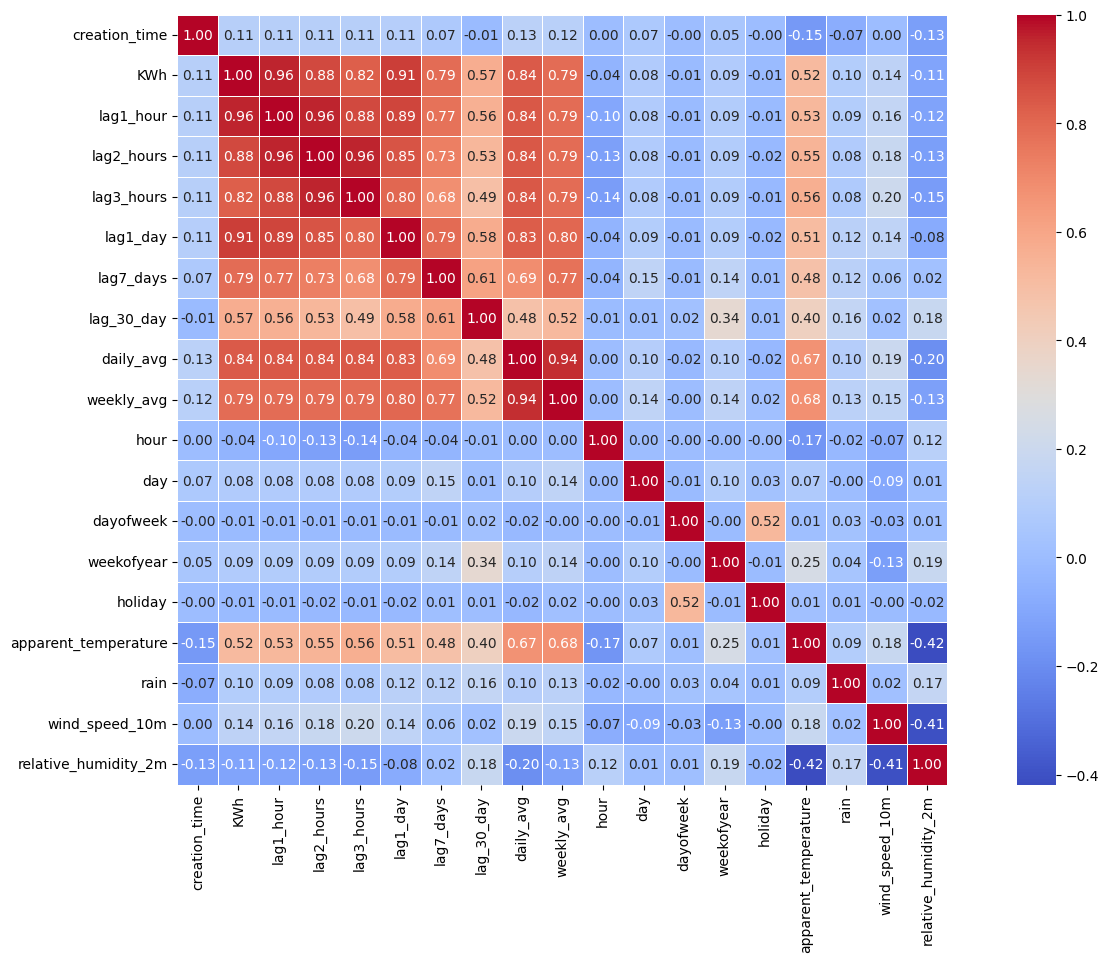

,creation_time,KWh,lag1_hour,lag2_hours,lag3_hours,lag1_day,lag7_days,lag_30_day,daily_avg,weekly_avg,hour,day,dayofweek,weekofyear,holiday,apparent_temperature,rain,wind_speed_10m,relative_humidity_2m
1443,2023-01-31 01:30:00,38.125,52.650,62.125,61.600,39.900,32.575,40.250,52.130208,49.703720,1,31,1,5,0,9.85,0.0,10.10,95.0
1444,2023-01-31 02:00:00,31.875,45.475,58.200,62.225,37.500,28.975,36.200,52.013021,49.712351,2,31,1,5,0,9.80,0.0,10.90,95.0
1445,2023-01-31 02:30:00,25.875,38.125,52.650,62.125,34.150,25.875,31.500,51.840625,49.712351,2,31,1,5,0,10.60,0.0,11.40,93.5
1446,2023-01-31 03:00:00,23.675,31.875,45.475,58.200,31.950,24.425,27.275,51.668229,49.710119,3,31,1,5,0,11.40,0.0,11.90,92.0
1447,2023-01-31 03:30:00,22.700,25.875,38.125,52.650,26.975,23.650,25.600,51.579167,49.707292,3,31,1,5,0,12.65,0.0,11.30,89.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
24811,2024-05-31 21:30:00,184.975,151.325,159.275,184.225,161.525,167.600,107.425,192.109896,188.663988,21,31,4,22,0,28.45,0.0,8.25,15.5
24812,2024-05-31 22:00:00,205.225,162.250,156.950,173.100,176.150,173.500,110.800,192.715625,188.758408,22,31,4,22,0,28.40,0.0,8.20,15.0
24813,2024-05-31 22:30:00,228.850,184.975,151.325,159.275,192.775,186.175,108.525,193.467187,188.885417,22,31,4,22,0,27.80,0.0,8.65,16.0
24814,2024-05-31 23:00:00,239.175,205.225,162.250,156.950,223.425,199.600,102.175,193.795312,189.003199,23,31,4,22,0,27.20,0.0,9.10,17.0


In [49]:

weather_df = pd.read_parquet("weather_data_2024_10_24.parquet")

latitude, longitude = "28.46072","77.537381" #"28.625361","77.376214"#, 28.628059,77.378912
from_date = resample_df.first_valid_index().date()
to_date = resample_df.last_valid_index().date()
print("from_date: ",from_date,"to_date: ",to_date)
# weather_df = weather_data_api(latitude,longitude,from_date,to_date,duration="30min")

holidays_lst= holidays_list(from_date,to_date)
print("holidays_lst:",holidays_lst)
df_lags = add_lags(resample_df,target_col="KWh")
df_features = create_features(df_lags)


for date in holidays_lst:
    df_features.loc[f"{date}", 'holiday'] = 1
final_df = df_features.merge(weather_df,on=["creation_time"])
# final_df.drop(['creation_time'],axis=1,inplace=True)
# final_df.fillna(0,inplace= True)
print(final_df.isna().sum())
final_df.dropna(inplace=True)
correlation_matrix(final_df)
final_df

In [50]:

print(final_df.isna().sum())
final_df.dropna(inplace=True)
# final_df.reset_index(drop=True, inplace=True)
final_df.set_index("creation_time",inplace=True)
# final_df.drop(['creation_time'],axis=1,inplace=True)
final_df


creation_time           0
KWh                     0
lag1_hour               0
lag2_hours              0
lag3_hours              0
lag1_day                0
lag7_days               0
lag_30_day              0
daily_avg               0
weekly_avg              0
hour                    0
day                     0
dayofweek               0
weekofyear              0
holiday                 0
apparent_temperature    0
rain                    0
wind_speed_10m          0
relative_humidity_2m    0
dtype: int64


,KWh,lag1_hour,lag2_hours,lag3_hours,lag1_day,lag7_days,lag_30_day,daily_avg,weekly_avg,hour,day,dayofweek,weekofyear,holiday,apparent_temperature,rain,wind_speed_10m,relative_humidity_2m
creation_time,,,,,,,,,,,,,,,,,,
2023-01-31 01:30:00,38.125,52.650,62.125,61.600,39.900,32.575,40.250,52.130208,49.703720,1,31,1,5,0,9.85,0.0,10.10,95.0
2023-01-31 02:00:00,31.875,45.475,58.200,62.225,37.500,28.975,36.200,52.013021,49.712351,2,31,1,5,0,9.80,0.0,10.90,95.0
2023-01-31 02:30:00,25.875,38.125,52.650,62.125,34.150,25.875,31.500,51.840625,49.712351,2,31,1,5,0,10.60,0.0,11.40,93.5
2023-01-31 03:00:00,23.675,31.875,45.475,58.200,31.950,24.425,27.275,51.668229,49.710119,3,31,1,5,0,11.40,0.0,11.90,92.0
2023-01-31 03:30:00,22.700,25.875,38.125,52.650,26.975,23.650,25.600,51.579167,49.707292,3,31,1,5,0,12.65,0.0,11.30,89.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2024-05-31 21:30:00,184.975,151.325,159.275,184.225,161.525,167.600,107.425,192.109896,188.663988,21,31,4,22,0,28.45,0.0,8.25,15.5
2024-05-31 22:00:00,205.225,162.250,156.950,173.100,176.150,173.500,110.800,192.715625,188.758408,22,31,4,22,0,28.40,0.0,8.20,15.0
2024-05-31 22:30:00,228.850,184.975,151.325,159.275,192.775,186.175,108.525,193.467187,188.885417,22,31,4,22,0,27.80,0.0,8.65,16.0


In [51]:
train_dataset = final_df.loc[~((final_df.index.month==5)& (final_df.index.year == 2024))]
# train_dataset.reset_index(drop=True,inplace=True)
train_dataset

,KWh,lag1_hour,lag2_hours,lag3_hours,lag1_day,lag7_days,lag_30_day,daily_avg,weekly_avg,hour,day,dayofweek,weekofyear,holiday,apparent_temperature,rain,wind_speed_10m,relative_humidity_2m
creation_time,,,,,,,,,,,,,,,,,,
2023-01-31 01:30:00,38.125,52.650,62.125,61.600,39.900,32.575,40.250,52.130208,49.703720,1,31,1,5,0,9.85,0.0,10.10,95.0
2023-01-31 02:00:00,31.875,45.475,58.200,62.225,37.500,28.975,36.200,52.013021,49.712351,2,31,1,5,0,9.80,0.0,10.90,95.0
2023-01-31 02:30:00,25.875,38.125,52.650,62.125,34.150,25.875,31.500,51.840625,49.712351,2,31,1,5,0,10.60,0.0,11.40,93.5
2023-01-31 03:00:00,23.675,31.875,45.475,58.200,31.950,24.425,27.275,51.668229,49.710119,3,31,1,5,0,11.40,0.0,11.90,92.0
2023-01-31 03:30:00,22.700,25.875,38.125,52.650,26.975,23.650,25.600,51.579167,49.707292,3,31,1,5,0,12.65,0.0,11.30,89.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2024-04-30 21:30:00,128.975,110.375,84.675,82.250,123.725,97.225,67.500,102.390104,99.747024,21,30,1,18,0,19.05,0.0,10.85,23.5
2024-04-30 22:00:00,128.100,124.625,95.975,80.750,118.325,94.350,69.950,102.593750,99.847470,22,30,1,18,0,19.10,0.0,9.70,23.0
2024-04-30 22:30:00,124.750,128.975,110.375,84.675,111.075,94.325,73.550,102.878646,99.938021,22,30,1,18,0,18.40,0.0,12.35,24.0


In [52]:

val_dataset = final_df.loc[(final_df.index.month==5)& (final_df.index.year == 2024)]
# val_dataset.reset_index(drop=True,inplace=True)
val_dataset

,KWh,lag1_hour,lag2_hours,lag3_hours,lag1_day,lag7_days,lag_30_day,daily_avg,weekly_avg,hour,day,dayofweek,weekofyear,holiday,apparent_temperature,rain,wind_speed_10m,relative_humidity_2m
creation_time,,,,,,,,,,,,,,,,,,
2024-05-01 00:00:00,140.975,128.375,128.100,124.625,122.475,80.800,85.4000,104.058854,100.418973,0,1,2,18,1,17.60,0.0,13.90,30.0
2024-05-01 00:30:00,146.900,136.200,124.750,128.975,126.150,82.150,82.6000,104.491146,100.611682,0,1,2,18,1,18.15,0.0,14.90,33.5
2024-05-01 01:00:00,146.700,140.975,128.375,128.100,127.200,84.200,79.3375,104.897396,100.797693,1,1,2,18,1,18.70,0.0,15.90,37.0
2024-05-01 01:30:00,142.825,146.900,136.200,124.750,127.000,87.275,76.2125,105.227083,100.963021,1,1,2,18,1,19.50,0.0,17.20,37.0
2024-05-01 02:00:00,138.175,146.700,140.975,128.375,126.750,89.425,77.9875,105.465104,101.108110,2,1,2,18,1,20.30,0.0,18.50,37.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2024-05-31 21:30:00,184.975,151.325,159.275,184.225,161.525,167.600,107.4250,192.109896,188.663988,21,31,4,22,0,28.45,0.0,8.25,15.5
2024-05-31 22:00:00,205.225,162.250,156.950,173.100,176.150,173.500,110.8000,192.715625,188.758408,22,31,4,22,0,28.40,0.0,8.20,15.0
2024-05-31 22:30:00,228.850,184.975,151.325,159.275,192.775,186.175,108.5250,193.467187,188.885417,22,31,4,22,0,27.80,0.0,8.65,16.0


In [53]:

target_variable = "KWh"
# train 
train_features = train_dataset.copy()   
train_label = train_features.pop(target_variable)
print(f"train_features shape: {train_features.shape}\ntrain_label shape: {train_label.shape}")

# val
val_features = val_dataset.copy()   
val_label = val_features.pop(target_variable)
print(f"val_feature shape: {val_features.shape}\nval_label shape: {val_label.shape}")

train_features shape: (21885, 17)
train_label shape: (21885,)
val_feature shape: (1488, 17)
val_label shape: (1488,)


<Axes: xlabel='creation_time'>

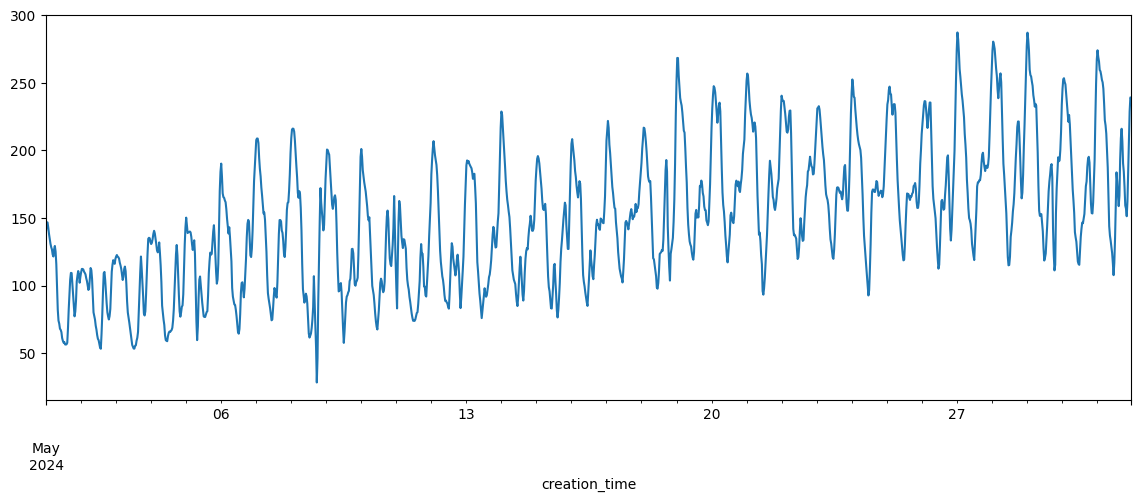

In [54]:
val_label.plot()

In [55]:
from sklearn.preprocessing import  MinMaxScaler,StandardScaler
feature_scaler = MinMaxScaler()
# Exclude the "Load_kW" column from features to normalize
# features_to_normalize = [col for col in train_dataset.columns if col not in target_variable]
# print(features_to_normalize)
# feature_scaler = StandardScaler()
# train_dataset[features_to_normalize] = feature_scaler.fit_transform(train_dataset[features_to_normalize])
col = train_features.columns
train_features[col] = feature_scaler.fit_transform(train_features)
train_features


,lag1_hour,lag2_hours,lag3_hours,lag1_day,lag7_days,lag_30_day,daily_avg,weekly_avg,hour,day,dayofweek,weekofyear,holiday,apparent_temperature,rain,wind_speed_10m,relative_humidity_2m
creation_time,,,,,,,,,,,,,,,,,
2023-01-31 01:30:00,0.171803,0.212009,0.209781,0.117700,0.086618,0.119185,0.092305,0.061574,0.043478,1.000000,0.166667,0.078431,0.0,0.222350,0.0,0.297935,0.945055
2023-01-31 02:00:00,0.141357,0.195354,0.212433,0.107516,0.071341,0.102000,0.091463,0.061650,0.086957,1.000000,0.166667,0.078431,0.0,0.221198,0.0,0.321534,0.945055
2023-01-31 02:30:00,0.110168,0.171803,0.212009,0.093301,0.058187,0.082056,0.090224,0.061650,0.086957,1.000000,0.166667,0.078431,0.0,0.239631,0.0,0.336283,0.928571
2023-01-31 03:00:00,0.083647,0.141357,0.195354,0.083965,0.052034,0.064128,0.088985,0.061630,0.130435,1.000000,0.166667,0.078431,0.0,0.258065,0.0,0.351032,0.912088
2023-01-31 03:30:00,0.058187,0.110168,0.171803,0.062855,0.048746,0.057020,0.088345,0.061605,0.130435,1.000000,0.166667,0.078431,0.0,0.286866,0.0,0.333333,0.879121
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2024-04-30 21:30:00,0.416751,0.307696,0.297406,0.473399,0.360951,0.234817,0.453482,0.503769,0.913043,0.966667,0.166667,0.333333,0.0,0.434332,0.0,0.320059,0.159341
2024-04-30 22:00:00,0.477218,0.355646,0.291041,0.450485,0.348751,0.245213,0.454946,0.504656,0.956522,0.966667,0.166667,0.333333,0.0,0.435484,0.0,0.286136,0.153846
2024-04-30 22:30:00,0.495677,0.416751,0.307696,0.419721,0.348645,0.260489,0.456993,0.505457,0.956522,0.966667,0.166667,0.333333,0.0,0.419355,0.0,0.364307,0.164835


In [107]:

with open('models/minmax_scaler.pkl', 'wb') as f:
    pickle.dump(feature_scaler, f)

MinMaxScaler()

Initial Train Score 0.9834328508337633
Fitting 5 folds for each of 10 candidates, totalling 50 fits
Best Parameters: {'subsample': 0.1, 'reg_lambda': 0.1, 'reg_alpha': 0.2, 'n_estimators': 600, 'max_depth': 40, 'learning_rate': 0.03, 'colsample_bytree': 0.6}
TRAIN SCORE with hyperparameters tunning: 0.995722265184485

Model Power Evaluation
Mean Absolute Error (MAE): 14.10074287332513
Root Mean Squared Error (RMSE): 19.16618169346347
R-squared: 0.8548156976705317


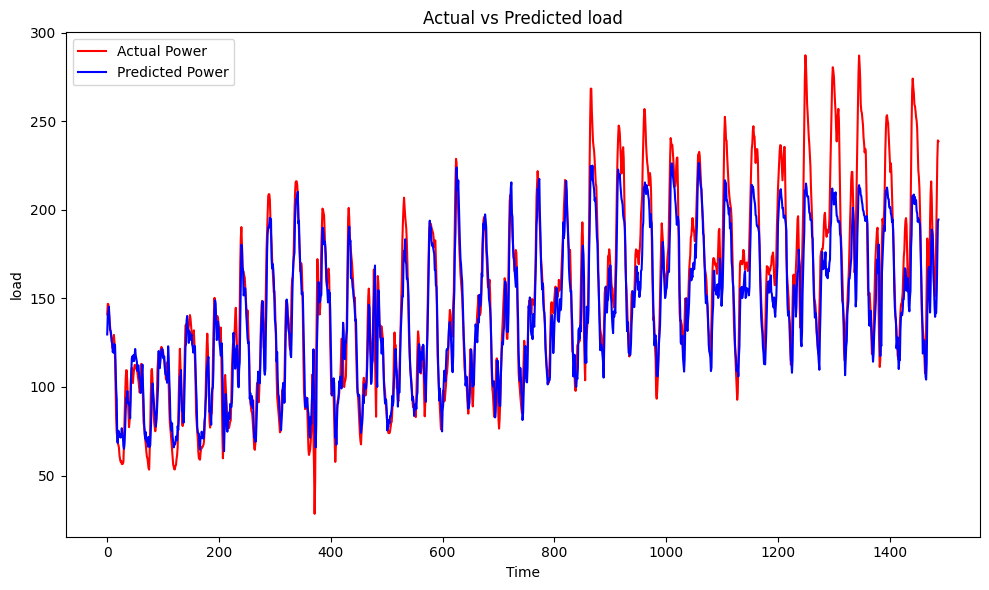

In [56]:
from sklearn.model_selection import TimeSeriesSplit

xgb_model = XGBRegressor()
xgb_model.fit(train_features, train_label)

# Calculate and print model evaluation metrics for this sensor
train_score = xgb_model.score(train_features, train_label)
print(f"Initial Train Score {train_score}")

# Perform hyperparameter tuning using RandomizedSearchCV
param_grid = {
        "n_estimators" : [200, 250, 300, 350,400, 450, 500, 550, 600, 650],       
        "max_depth": [ 10, 15, 20, 25, 30, 35, 40], # 1, 2, 3, 5,
        "learning_rate": [0.0001, 0.001,0.01, 0.1, 0.3, 0.02, 0.2, 1, 0.03],
        "subsample": [0.1, 0.5, 0.7, 0.3, 0.2,0.4, 0.6],
        "colsample_bytree":  [0.1, 0.5, 0.7, 0.3, 0.2,0.4,0.6],
        'reg_alpha': [0.01, 0.1, 0.3, 0.02, 0.2, 1, 0.03],
        'reg_lambda': [0.01, 0.1, 0.5, 1.0],  # Add L2 regularization

    # 'n_estimators': [100, 200, 300, 400, 500],
    # 'max_depth': [3, 5, 7, 10],
    # 'learning_rate': [0.01, 0.05, 0.1, 0.2],
    # 'subsample': [0.5, 0.7, 0.8, 1.0],
    # 'colsample_bytree': [0.5, 0.7, 1.0],
    # 'reg_alpha': [0.01, 0.1, 0.5, 1.0]

        # "n_estimators": [200, 250, 300, 350,400, 450, 500],
        # "max_depth": [3,5,10,15, 20, 25,30],
        # "learning_rate": [0.01, 0.1, 0.3, 0.02, 0.2, 1, 0.03],
        # "subsample": [0.1, 0.5, 0.7, 0.3, 0.2,0.4,0.6],
        # "colsample_bytree":  [0.1, 0.5, 0.7, 0.3, 0.2,0.4,0.6],
        # 'reg_alpha': [0.01, 0.1, 0.3, 0.02, 0.2, 1, 0.03],
        }

# random_search = RandomizedSearchCV(xgb_model,
#                                     param_distributions=param_grid,
#                                     n_iter=5,
#                                     scoring='neg_mean_squared_error',
#                                     cv=5,
#                                     random_state=100)

# # Fit the RandomizedSearchCV to the data
# # random_search.fit(X_train, y_train)
# random_search.fit(train_features, train_label)

tscv = TimeSeriesSplit(n_splits=5)
random_search = RandomizedSearchCV(
    estimator=xgb_model, 
    param_distributions=param_grid, 
    n_iter=10,
    scoring='neg_mean_squared_error',
    cv=tscv,  # Use time series split
    verbose=1,
    random_state=100
)

random_search.fit(train_features, train_label)


# Get the best parameters
best_params = random_search.best_params_
print(f"Best Parameters: {best_params}")

# Train the model with the best parameters
best_xgb_model = XGBRegressor(n_estimators=best_params['n_estimators'],
                                max_depth=best_params['max_depth'],
                                learning_rate=best_params['learning_rate'],
                                subsample=best_params['subsample'],
                                colsample_bytree=best_params['colsample_bytree'],
                                reg_alpha=best_params['reg_alpha'],
                                base_score=0.5,
                                booster='gbtree',
                                # reg_lambda=best_params['reg_lambda'],
                                objective='reg:squarederror')
best_xgb_model.fit(train_features, train_label)

# Evaluate the model on the test set
test_score = best_xgb_model.score(train_features, train_label)
print(f"TRAIN SCORE with hyperparameters tunning: {test_score}")

best_xgb_model
plot_prediction(val_label,best_xgb_model.predict(feature_scaler.transform(val_features)))
# plot_prediction(test_label, best_xgb_model.predict(feature_scaler.transform(test_features)))



In [28]:
import joblib

def save_model(model, model_dir="models"):
    # from datetime import datetime
    # timestamp = datetime.now().strftime('%Y%m%d_%H%M%S')
    model_path = f"{model_dir}/xgb_model_1.joblib"
    joblib.dump(model, model_path)
    return model_path
# save_model(xgb_model)

'models/xgb_model_1.joblib'

## LSTM

In [57]:
def reshape_fn(dataset):
    return np.array(dataset).reshape(((dataset.shape[0]),1,dataset.shape[1]))

In [58]:
train_features

,lag1_hour,lag2_hours,lag3_hours,lag1_day,lag7_days,lag_30_day,daily_avg,weekly_avg,hour,day,dayofweek,weekofyear,holiday,apparent_temperature,rain,wind_speed_10m,relative_humidity_2m
creation_time,,,,,,,,,,,,,,,,,
2023-01-31 01:30:00,0.171803,0.212009,0.209781,0.117700,0.086618,0.119185,0.092305,0.061574,0.043478,1.000000,0.166667,0.078431,0.0,0.222350,0.0,0.297935,0.945055
2023-01-31 02:00:00,0.141357,0.195354,0.212433,0.107516,0.071341,0.102000,0.091463,0.061650,0.086957,1.000000,0.166667,0.078431,0.0,0.221198,0.0,0.321534,0.945055
2023-01-31 02:30:00,0.110168,0.171803,0.212009,0.093301,0.058187,0.082056,0.090224,0.061650,0.086957,1.000000,0.166667,0.078431,0.0,0.239631,0.0,0.336283,0.928571
2023-01-31 03:00:00,0.083647,0.141357,0.195354,0.083965,0.052034,0.064128,0.088985,0.061630,0.130435,1.000000,0.166667,0.078431,0.0,0.258065,0.0,0.351032,0.912088
2023-01-31 03:30:00,0.058187,0.110168,0.171803,0.062855,0.048746,0.057020,0.088345,0.061605,0.130435,1.000000,0.166667,0.078431,0.0,0.286866,0.0,0.333333,0.879121
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2024-04-30 21:30:00,0.416751,0.307696,0.297406,0.473399,0.360951,0.234817,0.453482,0.503769,0.913043,0.966667,0.166667,0.333333,0.0,0.434332,0.0,0.320059,0.159341
2024-04-30 22:00:00,0.477218,0.355646,0.291041,0.450485,0.348751,0.245213,0.454946,0.504656,0.956522,0.966667,0.166667,0.333333,0.0,0.435484,0.0,0.286136,0.153846
2024-04-30 22:30:00,0.495677,0.416751,0.307696,0.419721,0.348645,0.260489,0.456993,0.505457,0.956522,0.966667,0.166667,0.333333,0.0,0.419355,0.0,0.364307,0.164835


In [59]:
val_features

,lag1_hour,lag2_hours,lag3_hours,lag1_day,lag7_days,lag_30_day,daily_avg,weekly_avg,hour,day,dayofweek,weekofyear,holiday,apparent_temperature,rain,wind_speed_10m,relative_humidity_2m
creation_time,,,,,,,,,,,,,,,,,
2024-05-01 00:00:00,128.375,128.100,124.625,122.475,80.800,85.4000,104.058854,100.418973,0,1,2,18,1,17.60,0.0,13.90,30.0
2024-05-01 00:30:00,136.200,124.750,128.975,126.150,82.150,82.6000,104.491146,100.611682,0,1,2,18,1,18.15,0.0,14.90,33.5
2024-05-01 01:00:00,140.975,128.375,128.100,127.200,84.200,79.3375,104.897396,100.797693,1,1,2,18,1,18.70,0.0,15.90,37.0
2024-05-01 01:30:00,146.900,136.200,124.750,127.000,87.275,76.2125,105.227083,100.963021,1,1,2,18,1,19.50,0.0,17.20,37.0
2024-05-01 02:00:00,146.700,140.975,128.375,126.750,89.425,77.9875,105.465104,101.108110,2,1,2,18,1,20.30,0.0,18.50,37.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2024-05-31 21:30:00,151.325,159.275,184.225,161.525,167.600,107.4250,192.109896,188.663988,21,31,4,22,0,28.45,0.0,8.25,15.5
2024-05-31 22:00:00,162.250,156.950,173.100,176.150,173.500,110.8000,192.715625,188.758408,22,31,4,22,0,28.40,0.0,8.20,15.0
2024-05-31 22:30:00,184.975,151.325,159.275,192.775,186.175,108.5250,193.467187,188.885417,22,31,4,22,0,27.80,0.0,8.65,16.0


(21885, 1, 17)
(1488, 1, 17)
Epoch 1/500
342/342 [==============================] - 4s 5ms/step - loss: 5436.4180 - val_loss: 17271.8008
Epoch 2/500
342/342 [==============================] - 1s 3ms/step - loss: 3340.9685 - val_loss: 13918.5322
Epoch 3/500
342/342 [==============================] - 1s 4ms/step - loss: 2389.2227 - val_loss: 11579.0254
Epoch 4/500
342/342 [==============================] - 1s 3ms/step - loss: 1886.6674 - val_loss: 9957.4824
Epoch 5/500
342/342 [==============================] - 1s 4ms/step - loss: 1502.8372 - val_loss: 8494.7275
Epoch 6/500
342/342 [==============================] - 1s 3ms/step - loss: 1137.8323 - val_loss: 7185.2944
Epoch 7/500
342/342 [==============================] - 1s 4ms/step - loss: 898.7882 - val_loss: 6118.2905
Epoch 8/500
342/342 [==============================] - 1s 4ms/step - loss: 726.9497 - val_loss: 5248.3979
Epoch 9/500
342/342 [==============================] - 1s 4ms/step - loss: 600.9691 - val_loss: 4522.3364
Epoch 10

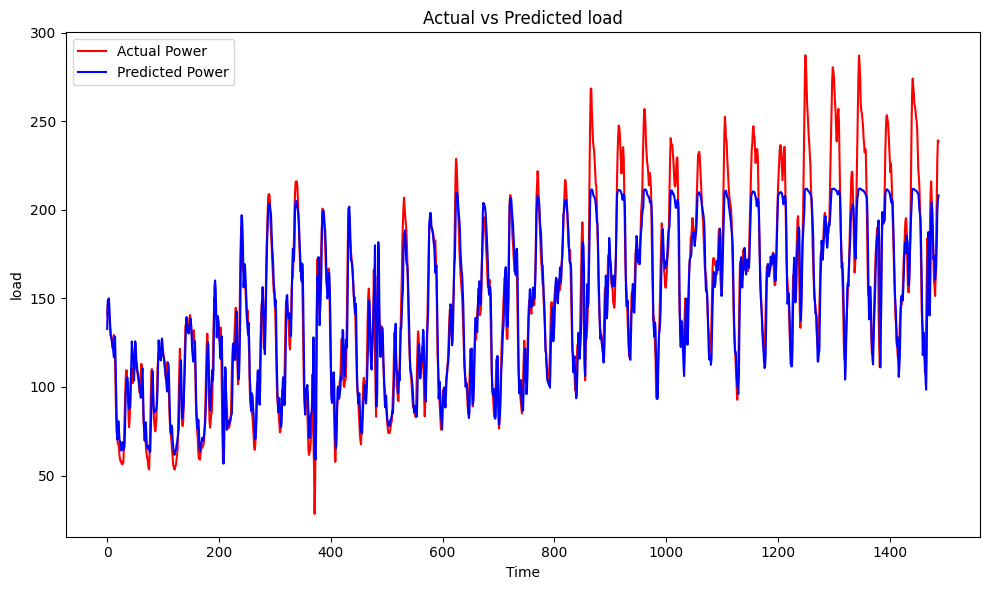

In [60]:

# # Reshaping data for LSTM (LSTM requires 3D shape: [samples, time_steps, features])
# reshaped_train_features = np.array(train_features).reshape((train_features.shape[0], 1, train_features.shape[1]))
# reshaped_val_features = np.array(val_features).reshape((val_features.shape[0], 1, val_features.shape[1]))
# reshaped_test_features = np.array(test_features).reshape((test_features.shape[0], 1, test_features.shape[1]))
reshaped_train_features= reshape_fn(train_features)
reshaped_val_features = reshape_fn(feature_scaler.transform(val_features))
# reshaped_test_features= reshape_fn(test_features)
print(reshaped_train_features.shape)
print(reshaped_val_features.shape)
# print(reshaped_test_features.shape)

#################################################################################################################################################################
from tensorflow.keras.regularizers import l2
from tensorflow.keras.optimizers import Adam
# from tensorflow.keras import Sequential
# from tensorflow.keras.layers import LSTM, Dropout, Dense
from tensorflow.keras.callbacks import EarlyStopping

# Build LSTM model with increased dropout and L2 regularization
lstm_model2 = Sequential([
    
    # Adding LSTM layers with increased dropout
    LSTM(units=64, return_sequences=True, input_shape=(reshaped_train_features.shape[1], reshaped_train_features.shape[2])),
    Dropout(0.3),  # Increased dropout
    LSTM(units=64, return_sequences=False),
    Dropout(0.3),  # Increased dropout
    # Adding dense output layer with L2 regularization
    Dense(units=1, kernel_regularizer=l2(0.01))  # L2 regularization
])

# Compile the model
lstm_model2.compile(optimizer=Adam(learning_rate=0.001), loss='mean_squared_error'
)

# Define early stopping callback
early_stopping = EarlyStopping(monitor='val_loss', patience=25, restore_best_weights=True)

# Train the model with early stopping
history = lstm_model2.fit(reshaped_train_features, train_label, epochs=500, batch_size=64, 
                         validation_data=(reshaped_val_features, val_label), 
                         callbacks=[early_stopping])

plot_prediction(val_label, lstm_model2.predict(reshaped_val_features))
# plot_prediction(val_label, xgb_model.predict(val_features))
# plot_prediction(test_label, lstm_model2.predict(reshape_fn(feature_scaler.transform(test_features))))


#################################################################################################################################################################

# # Build LSTM model
# lstm_model = Sequential()

# # Adding LSTM layers
# lstm_model.add(LSTM(units=64, return_sequences=True, input_shape=(reshaped_train_features.shape[1], reshaped_train_features.shape[2])))
# lstm_model.add(Dropout(0.2))  # Prevent overfitting
# lstm_model.add(LSTM(units=64, return_sequences=False))
# lstm_model.add(Dropout(0.2))

# # # Adding dense output layer
# lstm_model.add(Dense(units=1))  # Predicting the target variable

# # Compile the model
# lstm_model.compile(optimizer='adam', loss='mean_squared_error')
# # Train the model
# history = lstm_model.fit(reshaped_train_features, np.array(train_label), epochs=300, batch_size=64, validation_data=(reshaped_val_features, np.array(val_label)))
# plot_prediction(val_label, lstm_model.predict(reshaped_val_features))
# # plot_prediction(val_label, xgb_model.predict(val_features))
# # plot_prediction(test_label, lstm_model.predict(reshape_fn(feature_scaler.transform(test_features))))


In [61]:
lstm_model2

In [35]:
import joblib

def save_model(model, model_dir="models"):
    # from datetime import datetime
    # timestamp = datetime.now().strftime('%Y%m%d_%H%M%S')
    model_path = f"{model_dir}/lstm_model_1.joblib"
    joblib.dump(model, model_path)
    return model_path
# save_model(lstm_model2)

INFO:tensorflow:Assets written to: ram://36c24c78-8e95-47ac-8568-5ede26407da8/assets


INFO:tensorflow:Assets written to: ram://36c24c78-8e95-47ac-8568-5ede26407da8/assets


'models/lstm_model_1.joblib'

47/47 [==============================] - 0s 2ms/step

Model Power Evaluation
Mean Absolute Error (MAE): 11.585001914219186
Root Mean Squared Error (RMSE): 16.27676333901887
R-squared: 0.8952908683296429


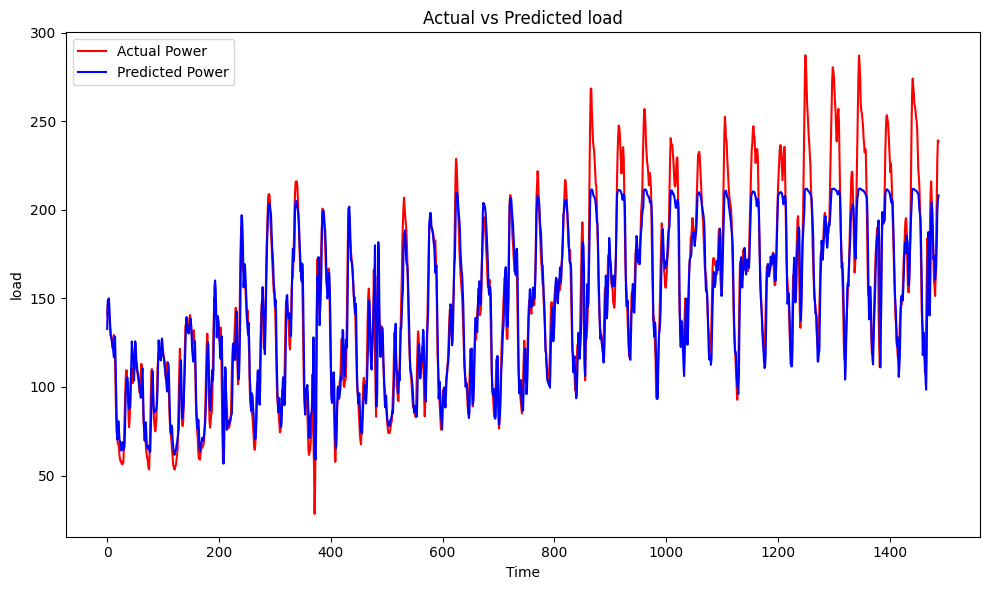

In [62]:
plot_prediction(val_label, lstm_model2.predict(reshaped_val_features))

In [63]:
train_label.describe()

count    21885.000000
mean        78.660452
std         38.449819
min         12.162500
25%         49.300000
50%         69.300000
75%         99.575000
max        247.825000
Name: KWh, dtype: float64

In [64]:
pred = lstm_model2.predict(reshaped_val_features)
pd.DataFrame(pred).describe()

47/47 [==============================] - 0s 2ms/step


,0
count,1488.000000
mean,145.735947
std,42.926468
min,56.683517
25%,109.772007
50%,146.603348
75%,182.724255
max,211.917511


2/2 [==============================] - 0s 4ms/step

Model Power Evaluation
Mean Absolute Error (MAE): 13.24752283096313
Root Mean Squared Error (RMSE): 19.470399443602197
R-squared: 0.7820306008631027


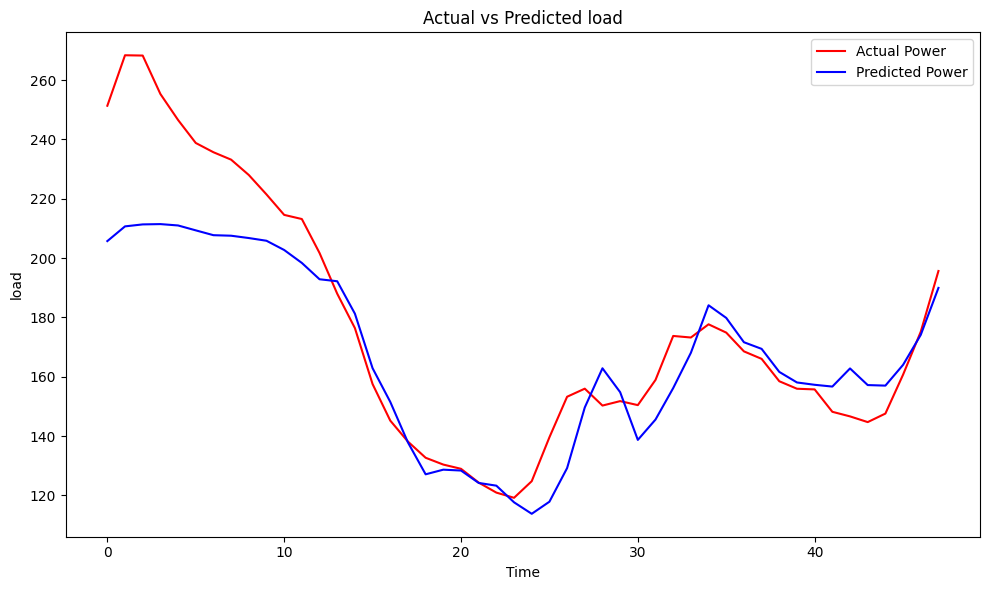

In [65]:
def feature_extraction(dataset,target_variable):
    dataset_feature = dataset.copy()
    dataset_label = dataset_feature.pop(target_variable)
    return dataset_feature,dataset_label

def prediction_function(dataset,day,target_variable,scaler,model):
    test_dataset = dataset[dataset['day']==day]

    dataset_feature,dataset_label = feature_extraction(test_dataset,target_variable)
    scaled_feature = scaler.transform(dataset_feature[dataset_feature['day']==day])
    # print(np.array(dataset_label))
    # if model == "LSTM":
    reshaped_dataset_feature = reshape_fn(scaled_feature)
    # else:
        # reshaped_dataset_feature = dataset_feature.copy()
    
    predicted_values = plot_prediction(np.array(dataset_label), model.predict(reshaped_dataset_feature))
    
    return predicted_values

# reshaped_val_features = reshape_fn(feature_scaler.transform(val_features[val_features['day']==31]))
# len(val_label[-49:-1])

prediction_function(val_dataset,19,target_variable,feature_scaler,lstm_model2,)

In [69]:
def pre_processing(data):
    print(f"df rows: {len(data)}")
    print(f"Duplicated rows: {data.duplicated().sum()}")
    data['creation_time'] = pd.to_datetime(data['creation_time'])

    data.set_index("creation_time", drop=True, inplace=True)
    # df = df.loc[df.index.year>2022]
    # df = df.loc[~ ((df.index.year==2024) & (df.index.month>5))]

    print(f"Duplicated rows after datetime index: {data.duplicated().sum()}")
    data = data.drop_duplicates()
    # data = data[data['R_Voltage'] != 0]
    # df = df.loc[~df['R_Voltage'] == 0]
    print(f"Duplicated index: {data.index.duplicated().sum()}")
    print(f"null_values : \n{data.isna().sum()}")
    print(f"df rows after basic checks: {len(data)}")
    
    # df.loc[(df['R_Voltage']<5000 )| (df['Y_Voltage']<5000 )|(df['B_Voltage']<5000 )]
    # df.loc[(df['R_Current']<1 )| (df['Y_Current']<1 )|(df['B_Current']<1 )]
    # data.set_index("creation_time",inplace=True)
    # data.set_index("creation_time",inplace=True,drop=True)
    # print(data.info())
    resample_df = data[['KWh']].resample(rule="30min").asfreq()
    print(f"null vlaues after resampling: {resample_df.isna().sum().sum()}")
    # resample_df[resample_df.isna().any(axis=1)]
    resample_df = resample_df.interpolate(method="linear")
    print(f"null values after filling: {resample_df.isna().sum().sum()}")
    resample_df['KWh'].plot()
    plt.show()

    weather_df = pd.read_parquet("weather_data_2024_10_24.parquet")
    from_date = resample_df.first_valid_index().date()
    to_date = resample_df.last_valid_index().date()
    print("from_date: ",from_date,"to_date: ",to_date)

    holidays_lst= holidays_list(from_date,to_date)
    print("holidays_lst:",holidays_lst)
    # df_lags = add_lags(resample_df,target_col="KWh")
    # df_features = create_features(df_lags)
    # print(df_features.head(2))
    # resample_df['holiday']=0
    # for date in holidays_lst:
    #     resample_df.loc[f"{date}", 'holiday'] = 1

    return resample_df
    # final_df = df_features.merge(weather_df,on=["creation_time"])
    # # final_df.drop(['creation_time'],axis=1,inplace=True)
    # # final_df.fillna(0,inplace= True)
    # final_df.dropna(inplace=True)
    # # correlation_matrix(final_df)
    # final_df.isna().sum()
    # final_df.dropna(inplace=True)
    # # final_df.reset_index(drop=True, inplace=True)
    # final_df.set_index("creation_time",inplace=True)
    # # final_df.drop(['creation_time'],axis=1,inplace=True)
    # return final_df


In [70]:
val_dataset

,KWh,lag1_hour,lag2_hours,lag3_hours,lag1_day,lag7_days,lag_30_day,daily_avg,weekly_avg,hour,day,dayofweek,weekofyear,holiday,apparent_temperature,rain,wind_speed_10m,relative_humidity_2m
creation_time,,,,,,,,,,,,,,,,,,
2024-05-01 00:00:00,140.975,128.375,128.100,124.625,122.475,80.800,85.4000,104.058854,100.418973,0,1,2,18,1,17.60,0.0,13.90,30.0
2024-05-01 00:30:00,146.900,136.200,124.750,128.975,126.150,82.150,82.6000,104.491146,100.611682,0,1,2,18,1,18.15,0.0,14.90,33.5
2024-05-01 01:00:00,146.700,140.975,128.375,128.100,127.200,84.200,79.3375,104.897396,100.797693,1,1,2,18,1,18.70,0.0,15.90,37.0
2024-05-01 01:30:00,142.825,146.900,136.200,124.750,127.000,87.275,76.2125,105.227083,100.963021,1,1,2,18,1,19.50,0.0,17.20,37.0
2024-05-01 02:00:00,138.175,146.700,140.975,128.375,126.750,89.425,77.9875,105.465104,101.108110,2,1,2,18,1,20.30,0.0,18.50,37.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2024-05-31 21:30:00,184.975,151.325,159.275,184.225,161.525,167.600,107.4250,192.109896,188.663988,21,31,4,22,0,28.45,0.0,8.25,15.5
2024-05-31 22:00:00,205.225,162.250,156.950,173.100,176.150,173.500,110.8000,192.715625,188.758408,22,31,4,22,0,28.40,0.0,8.20,15.0
2024-05-31 22:30:00,228.850,184.975,151.325,159.275,192.775,186.175,108.5250,193.467187,188.885417,22,31,4,22,0,27.80,0.0,8.65,16.0


df rows: 1438
Duplicated rows: 0
Duplicated rows after datetime index: 0
Duplicated index: 0
null_values : 
R_Voltage    0
Y_Voltage    0
B_Voltage    0
R_Current    0
Y_Current    0
B_Current    0
KWh          0
dtype: int64
df rows after basic checks: 1438
null vlaues after resampling: 2
null values after filling: 0


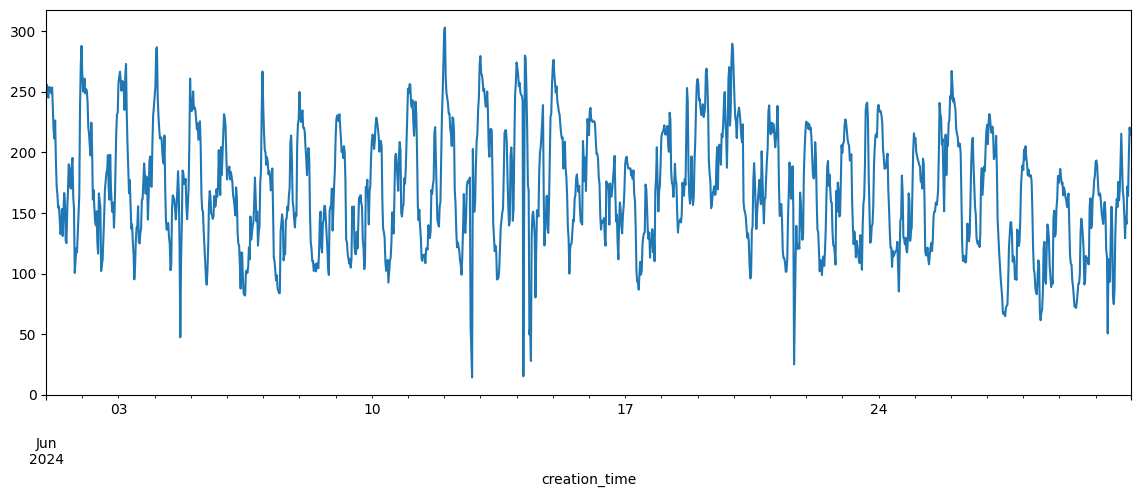

from_date:  2024-06-01 to_date:  2024-06-30
holidays_lst: [datetime.date(2024, 6, 2), datetime.date(2024, 6, 9), datetime.date(2024, 6, 16), datetime.date(2024, 6, 17), datetime.date(2024, 6, 23), datetime.date(2024, 6, 30)]


,KWh
creation_time,
2024-06-01 00:00:00,246.8
2024-06-01 00:30:00,256.0
2024-06-01 01:00:00,247.8
2024-06-01 01:30:00,245.2
2024-06-01 02:00:00,254.1
...,...
2024-06-30 21:30:00,164.2
2024-06-30 22:00:00,196.5
2024-06-30 22:30:00,220.6


In [71]:
x =  pd.read_csv("test_data/data_06_2024.csv")
x
# test_dataset = pd.concat()

# # test_dataset
clean_test = pre_processing(x) 
clean_test  

In [84]:
resample_df.loc[(resample_df.index.year == 2024) & (resample_df.index.month >3)]

,KWh
creation_time,
2024-04-01 00:00:00,85.4000
2024-04-01 00:30:00,82.6000
2024-04-01 01:00:00,79.3375
2024-04-01 01:30:00,76.2125
2024-04-01 02:00:00,77.9875
...,...
2024-05-31 21:30:00,184.9750
2024-05-31 22:00:00,205.2250
2024-05-31 22:30:00,228.8500


In [94]:
train_dataset.head(1)

,KWh,lag1_hour,lag2_hours,lag3_hours,lag1_day,lag7_days,lag_30_day,daily_avg,weekly_avg,hour,day,dayofweek,weekofyear,holiday,apparent_temperature,rain,wind_speed_10m,relative_humidity_2m
creation_time,,,,,,,,,,,,,,,,,,
2023-01-31 01:30:00,38.125,52.65,62.125,61.6,39.9,32.575,40.25,52.130208,49.70372,1,31,1,5,0,9.85,0.0,10.1,95.0


In [96]:
test2= pd.concat((resample_df.loc[(resample_df.index.year == 2024) & (resample_df.index.month >3)],clean_test))
# test2['holiday']=0

weather_df = pd.read_parquet("weather_data_2024_10_24.parquet")
from_date = test2.first_valid_index().date()
to_date = test2.last_valid_index().date()
print("from_date: ",from_date,"to_date: ",to_date)

holidays_lst= holidays_list(from_date,to_date)
print("holidays_lst:",holidays_lst)
holidays_lst= holidays_list(from_date,to_date)

test_df_lags= add_lags(test2,target_col="KWh")
test_df_features = create_features(test_df_lags)
# test_df_features
for date in holidays_lst:
    test2.loc[f"{date}", 'holiday'] = 1
final_test_df = test_df_features.merge(weather_df,on=["creation_time"])
# final_df.drop(['creation_time'],axis=1,inplace=True)
# final_df.fillna(0,inplace= True)
# final_df.dropna(inplace=True)
# correlation_matrix(final_df)
final_test_df.set_index("creation_time",drop=True,inplace=True)
test_dataset = final_test_df.loc[final_test_df.index.month== 6]
print(test_dataset.isna().sum().sum())
test_dataset

from_date:  2024-04-01 to_date:  2024-06-30
holidays_lst: [datetime.date(2024, 4, 7), datetime.date(2024, 4, 10), datetime.date(2024, 4, 11), datetime.date(2024, 4, 14), datetime.date(2024, 4, 21), datetime.date(2024, 4, 28), datetime.date(2024, 5, 1), datetime.date(2024, 5, 5), datetime.date(2024, 5, 12), datetime.date(2024, 5, 19), datetime.date(2024, 5, 26), datetime.date(2024, 6, 2), datetime.date(2024, 6, 9), datetime.date(2024, 6, 16), datetime.date(2024, 6, 17), datetime.date(2024, 6, 23), datetime.date(2024, 6, 30)]
0


,KWh,lag1_hour,lag2_hours,lag3_hours,lag1_day,lag7_days,lag_30_day,daily_avg,weekly_avg,hour,day,dayofweek,weekofyear,holiday,apparent_temperature,rain,wind_speed_10m,relative_humidity_2m
creation_time,,,,,,,,,,,,,,,,,,
2024-06-01 00:00:00,246.8,239.175,205.225,162.250,267.375,223.550,109.925,193.147396,189.156101,0,1,5,22,0,27.80,0.00,9.50,17.0
2024-06-01 00:30:00,256.0,238.625,228.850,184.975,274.025,234.050,112.350,192.771875,189.221429,0,1,5,22,0,29.60,0.00,11.95,15.5
2024-06-01 01:00:00,247.8,246.800,239.175,205.225,269.050,237.175,112.350,192.329167,189.253051,1,1,5,22,0,31.40,0.00,14.40,14.0
2024-06-01 01:30:00,245.2,256.000,238.625,228.850,265.875,244.725,111.900,191.898437,189.254464,1,1,5,22,0,32.80,0.00,15.40,15.0
2024-06-01 02:00:00,254.1,247.800,246.800,239.175,259.450,247.150,110.325,191.786979,189.275149,2,1,5,22,0,34.20,0.00,16.40,16.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2024-06-30 21:30:00,164.2,141.000,129.200,162.400,139.600,203.800,184.975,149.452083,152.128869,21,30,6,26,0,31.40,0.15,8.70,94.0
2024-06-30 22:00:00,196.5,171.900,147.000,148.200,162.100,213.800,205.225,150.168750,152.077381,22,30,6,26,0,31.80,0.10,5.20,94.0
2024-06-30 22:30:00,220.6,164.200,141.000,129.200,165.500,215.400,228.850,151.316667,152.092857,22,30,6,26,0,31.45,0.60,7.00,94.0


In [98]:
test_features = test_dataset.copy()
test_label = test_features.pop("KWh")
print(f"test_features shape: {test_features.shape}\ntest_label shape: {test_label.shape}")

test_features shape: (1440, 17)
test_label shape: (1440,)



Model Power Evaluation
Mean Absolute Error (MAE): 21.34795956823561
Root Mean Squared Error (RMSE): 29.631008695127175
R-squared: 0.6267020548709051


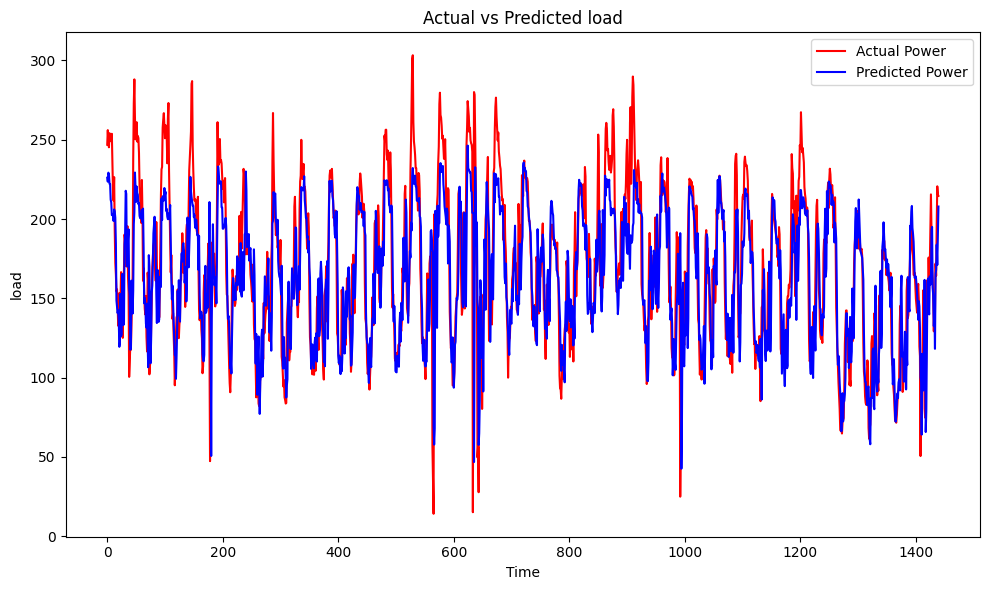

In [100]:
plot_prediction(test_label,xgb_model.predict(feature_scaler.transform(test_features)))

In [104]:
pd.DataFrame(feature_scaler.transform(test_features)).describe()

,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16
count,1440.000000,1440.000000,1440.000000,1440.000000,1440.000000,1440.000000,1440.000000,1440.000000,1440.000000,1440.000000,1440.000000,1440.000000,1440.0,1440.000000,1440.000000,1440.000000,1440.000000
mean,0.667263,0.667313,0.667346,0.672886,0.703805,0.590672,0.937700,1.163574,0.500000,0.483333,0.527778,0.457516,0.0,0.830162,0.018512,0.379403,0.331689
std,0.206030,0.206075,0.206083,0.207397,0.202474,0.212060,0.134224,0.082314,0.301069,0.288615,0.339189,0.024464,0.0,0.089228,0.108459,0.188580,0.274208
min,0.008646,0.008646,0.008646,0.008646,0.008646,0.068848,0.632385,0.965821,0.000000,0.000000,0.000000,0.411765,0.0,0.589862,0.000000,0.029499,-0.021978
25%,0.513605,0.513605,0.513605,0.515197,0.553175,0.430276,0.855037,1.101739,0.250000,0.233333,0.166667,0.431373,0.0,0.765841,0.000000,0.235988,0.109890
50%,0.653424,0.653424,0.653424,0.661698,0.684666,0.577680,0.968991,1.175382,0.500000,0.483333,0.500000,0.450980,0.0,0.829493,0.000000,0.331121,0.233516
75%,0.825386,0.825386,0.825386,0.833660,0.863682,0.731077,1.030515,1.216369,0.750000,0.733333,0.833333,0.470588,0.0,0.900922,0.000000,0.522124,0.549451
max,1.234976,1.234976,1.234976,1.234976,1.234976,1.167082,1.299593,1.302183,1.000000,0.966667,1.000000,0.490196,0.0,1.013825,1.953846,1.070796,0.945055


## using standard scalar

In [ ]:
from sklearn.preprocessing import  MinMaxScaler,StandardScaler
# feature_scaler = MinMaxScaler()
target_variable = "KWh"
# Exclude the "Load_kW" column from features to normalize
features_to_normalize = [col for col in train_dataset.columns if col not in target_variable]
# print(features_to_normalize)
feature_scaler = StandardScaler()
train_dataset[features_to_normalize] = feature_scaler.fit_transform(train_dataset[features_to_normalize])

# train 
train_features = train_dataset.copy()   
train_label = train_features.pop(target_variable)
print(f"train_features shape: {train_features.shape}\ntrain_label shape: {train_label.shape}")

# val
val_features = val_dataset.copy()   
val_label = val_features.pop(target_variable)
print(f"val_feature shape: {val_features.shape}\nval_label shape: {val_label.shape}")

In [ ]:
from sklearn.model_selection import TimeSeriesSplit

xgb_model = XGBRegressor()
xgb_model.fit(train_features, train_label)

# Calculate and print model evaluation metrics for this sensor
train_score = xgb_model.score(train_features, train_label)
print(f"Initial Train Score {train_score}")

# Perform hyperparameter tuning using RandomizedSearchCV
param_grid = {
        "n_estimators" : [200, 250, 300, 350,400, 450, 500, 550, 600, 650],       
        "max_depth": [ 10, 15, 20, 25, 30, 35, 40], # 1, 2, 3, 5,
        "learning_rate": [0.0001, 0.001,0.01, 0.1, 0.3, 0.02, 0.2, 1, 0.03],
        "subsample": [0.1, 0.5, 0.7, 0.3, 0.2,0.4, 0.6],
        "colsample_bytree":  [0.1, 0.5, 0.7, 0.3, 0.2,0.4,0.6],
        'reg_alpha': [0.01, 0.1, 0.3, 0.02, 0.2, 1, 0.03],
        'reg_lambda': [0.01, 0.1, 0.5, 1.0],  # Add L2 regularization

    # 'n_estimators': [100, 200, 300, 400, 500],
    # 'max_depth': [3, 5, 7, 10],
    # 'learning_rate': [0.01, 0.05, 0.1, 0.2],
    # 'subsample': [0.5, 0.7, 0.8, 1.0],
    # 'colsample_bytree': [0.5, 0.7, 1.0],
    # 'reg_alpha': [0.01, 0.1, 0.5, 1.0]

        # "n_estimators": [200, 250, 300, 350,400, 450, 500],
        # "max_depth": [3,5,10,15, 20, 25,30],
        # "learning_rate": [0.01, 0.1, 0.3, 0.02, 0.2, 1, 0.03],
        # "subsample": [0.1, 0.5, 0.7, 0.3, 0.2,0.4,0.6],
        # "colsample_bytree":  [0.1, 0.5, 0.7, 0.3, 0.2,0.4,0.6],
        # 'reg_alpha': [0.01, 0.1, 0.3, 0.02, 0.2, 1, 0.03],
        }

# random_search = RandomizedSearchCV(xgb_model,
#                                     param_distributions=param_grid,
#                                     n_iter=5,
#                                     scoring='neg_mean_squared_error',
#                                     cv=5,
#                                     random_state=100)

# # Fit the RandomizedSearchCV to the data
# # random_search.fit(X_train, y_train)
# random_search.fit(train_features, train_label)

tscv = TimeSeriesSplit(n_splits=5)
random_search = RandomizedSearchCV(
    estimator=xgb_model, 
    param_distributions=param_grid, 
    n_iter=10,
    scoring='neg_mean_squared_error',
    cv=tscv,  # Use time series split
    verbose=1,
    random_state=100
)

random_search.fit(train_features, train_label)


# Get the best parameters
best_params = random_search.best_params_
print(f"Best Parameters: {best_params}")

# Train the model with the best parameters
best_xgb_model = XGBRegressor(n_estimators=best_params['n_estimators'],
                                max_depth=best_params['max_depth'],
                                learning_rate=best_params['learning_rate'],
                                subsample=best_params['subsample'],
                                colsample_bytree=best_params['colsample_bytree'],
                                reg_alpha=best_params['reg_alpha'],
                                base_score=0.5,
                                booster='gbtree',
                                # reg_lambda=best_params['reg_lambda'],
                                objective='reg:squarederror')
best_xgb_model.fit(train_features, train_label)

# Evaluate the model on the test set
test_score = best_xgb_model.score(train_features, train_label)
print(f"TRAIN SCORE with hyperparameters tunning: {test_score}")

best_xgb_model
plot_prediction(val_label,best_xgb_model.predict(feature_scaler.transform(val_features)))
# plot_prediction(test_label, best_xgb_model.predict(feature_scaler.transform(test_features)))



In [ ]:

# # Reshaping data for LSTM (LSTM requires 3D shape: [samples, time_steps, features])
# reshaped_train_features = np.array(train_features).reshape((train_features.shape[0], 1, train_features.shape[1]))
# reshaped_val_features = np.array(val_features).reshape((val_features.shape[0], 1, val_features.shape[1]))
# reshaped_test_features = np.array(test_features).reshape((test_features.shape[0], 1, test_features.shape[1]))
reshaped_train_features=reshape_fn(train_features)
reshaped_val_features = reshape_fn(feature_scaler.transform(val_features))
# reshaped_test_features= reshape_fn(test_features)
print(reshaped_train_features.shape)
print(reshaped_val_features.shape)
# print(reshaped_test_features.shape)

# Build LSTM model
lstm_model = Sequential()

# Adding LSTM layers
lstm_model.add(LSTM(units=64, return_sequences=True, input_shape=(reshaped_train_features.shape[1], reshaped_train_features.shape[2])))
lstm_model.add(Dropout(0.2))  # Prevent overfitting
lstm_model.add(LSTM(units=64, return_sequences=False))
lstm_model.add(Dropout(0.2))

# # Adding dense output layer
lstm_model.add(Dense(units=1))  # Predicting the target variable

# Compile the model
lstm_model.compile(optimizer='adam', loss='mean_squared_error')
# Train the model
history = lstm_model.fit(reshaped_train_features, np.array(train_label), epochs=100, batch_size=64, validation_data=(reshaped_val_features, np.array(val_label)))
plot_prediction(val_label, lstm_model.predict(reshaped_val_features))
# plot_prediction(val_label, xgb_model.predict(val_features))
# plot_prediction(test_label, lstm_model.predict(reshape_fn(feature_scaler.transform(test_features))))
